# Synthesis of a pseudo-mainnet

## Set up packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Read data files

In [2]:
ptNodes <- fread("pt_nodes.csv", stringsAsFactors=TRUE)
ptNodes %>% summary

                                                                id      
 0049eca4703be755cef74ed20e1815b50b5fa0ceb07c6b822c78355dd12fdaa6:   1  
 0078d0f5d825d8946e0809e85fe0f21589294cae912104b3ca9f0e4bb93552c3:   1  
 008c441677a37d339c96a2bf2c9aa377e2411a00eb9d4588e3362043f0d7b744:   1  
 012200f2a61b1d302998036a06091f074f95125848e9caff9f0d23e392538936:   1  
 012c09d9b08f7c26d9076a0aea43ead69de74de251de49c6ba67e40d0613053b:   1  
 01567bed7019b7452a243cb66b3e8cc433c2eafe4d7569e49227d61bcfd6d33f:   1  
 (Other)                                                         :2195  
               n2n_version   peer_sharing      asn                   country   
 NodeToNodeVersionV10:   1   f: 745       Min.   :   209   Germany       :528  
 NodeToNodeVersionV11:   1   t:1456       1st Qu.: 14061   United States :502  
 NodeToNodeVersionV13: 869                Median : 20860   Canada        :154  
 NodeToNodeVersionV14:1330                Mean   : 61266   Japan         :123  
                

In [3]:
ptEdges <- fread("pt_edges.csv", stringsAsFactors=TRUE)
ptEdges %>% summary

                                                              source     
 99f4b029b0864e19334824015c8d05b34c34353ab7fe36e9da91689ceb512b66:   67  
 7e0520b4ebf8159bd1e219d49fc847efc9fe54332cc36aa5ac2350020c2a4939:   64  
 624d8747537834fe5aa3da126f5647904f2425fb002c72be6fe811fbd671412b:   61  
 73a4c479d08b254dab522708a611981c48e8323ae39ab6ad838c30ba3c8c8811:   59  
 1b80ab54864c57bf4f1e9646d30edf48e4d98e8d70ecaacac89adb3a48be5726:   57  
 4a5c7640e2e4f40870dfe3df1fe942e90f718394bd68de31e5ec9730c5ece414:   57  
 (Other)                                                         :49569  
                                                              target     
 99f4b029b0864e19334824015c8d05b34c34353ab7fe36e9da91689ceb512b66:  194  
 2d8b0cb5e44c3e746e7e29fb025dcb258aaf4df658f41c11bdc6824a9059fb84:  185  
 9b88f53637710f0b577b5cc060e67ceb1fddbee24c18f600b4497829d2e2323f:  181  
 d651218f17c10c040eb944416864971abd396ff8142bda7e2d97e26a7fc3a987:  177  
 d0cca0575254a0c01423d9532b4223e4dc467

In [4]:
poolCountries <- fread("pool_country.csv", stringsAsFactors=TRUE)
poolCountries %>% summary

    epoch_no        country    no_of_pools         stake           
 Min.   :524   Australia: 1   Min.   :  1.00   Min.   :    120272  
 1st Qu.:524   Austria  : 1   1st Qu.:  1.00   1st Qu.:  32641441  
 Median :524   Belgium  : 1   Median :  5.00   Median :  94785845  
 Mean   :524   Bolivia  : 1   Mean   : 37.09   Mean   : 616847011  
 3rd Qu.:524   Brazil   : 1   3rd Qu.: 23.50   3rd Qu.: 517550850  
 Max.   :524   Canada   : 1   Max.   :537.00   Max.   :7077609940  
               (Other)  :29                                        

In [5]:
countryBoundingBoxes <- fread("country-boundingboxes.csv", stringsAsFactors=TRUE)
countryBoundingBoxes %>% summary

        country    ISO3166 country code    longmin              latmin       
 AT         :  1      :248              Min.   :-179.9850   Min.   :-78.000  
 AV         :  1   ABW:  1              1st Qu.: -59.9168   1st Qu.: -7.080  
 Afghanistan:  1   AE :  1              Median :  10.0000   Median : 10.000  
 Albania    :  1   AT :  1              Mean   :  -0.1206   Mean   :  9.275  
 Algeria    :  1   ATG:  1              3rd Qu.:  39.6500   3rd Qu.: 32.858  
 Andorra    :  1   AV :  1              Max.   : 176.1000   Max.   : 62.000  
 (Other)    :248   BD :  1                                                   
    longmax              latmax           Wrapped   
 Min.   :-174.4170   Min.   :-54.386          :242  
 1st Qu.:   0.4457   1st Qu.:  9.544   WRAPPED: 12  
 Median :  32.5915   Median : 21.000                
 Mean   :  35.9674   Mean   : 23.508                
 3rd Qu.:  75.0000   3rd Qu.: 42.918                
 Max.   : 180.0000   Max.   : 89.000                
     

## Create ASN-level totals

### Compare node countries to pool countries

All of the pool countries appear in the list of node countries.

In [6]:
poolCountries[!(`country` %in% ptNodes$`country`), unique(`country`)]

factor(0)
35 Levels: Australia Austria Belgium Bolivia Brazil Canada China ... United States

Twenty-one of the node countries do not appear in the list of pool countries.

In [7]:
ptNodes[!(`country` %in% poolCountries$`country`), unique(`country`)]

[1]                Estonia        Argentina      Viet Nam       Czechia       
 [6] Italy          Portugal       Slovenia       Greece         Denmark       
[11] Chile          Cayman Islands Israel         Malaysia       Luxembourg    
[16] New Caledonia  Iran           Malta          Bulgaria       Mexico        
[21] Peru          
56 Levels:  Argentina Australia Austria Belgium Bolivia Brazil ... Viet Nam

### Use hot-deck imputation to assign missing nodes to countries and ASNs

If the country is missing, then the ASN is also missing.

In [8]:
ptNodes[, .N, .(`Has Country`=`country`!="", `Has ASN`=!is.na(`asn`))]

Has Country,Has ASN,N
<lgl>,<lgl>,<int>
FALSE,FALSE,64
TRUE,TRUE,2137


In [9]:
nonMissing <- ptNodes[`country` != "", .(`country`, `asn`)]
nonMissing %>% dim

[1] 2137    2

In [10]:
nrow(nonMissing)

[1] 2137

In [11]:
assignments <- sample(1:nrow(nonMissing), ptNodes[`country`=="", .N])

In [12]:
ptNodes[`country` =="", `:=`(`country`=nonMissing[assignments, `country`], `asn`=nonMissing[assignments, `asn`])]

### Distribute the stake among the ASNs

In [13]:
nodeFractions <- ptNodes[, .(`no_of_nodes`=.N), .(`country`, `asn`)][, .(`asn`, `no_of_nodes`, `fraction`=`no_of_nodes`/sum(`no_of_nodes`)), .(`country`)]
nodeFractions %>% head

country,asn,no_of_nodes,fraction
<fct>,<int>,<int>,<dbl>
United States,40021,85,0.16601562
United States,14618,30,0.05859375
United States,396982,33,0.06445312
United States,5650,8,0.01562500
United States,16509,28,0.05468750
United States,16591,8,0.01562500


Randomly distribute the pools to ASNs according to a multinomial distribution weighted by the number of nodes in the ASN.

In [14]:
rpools <- function(no_of_pools, fractions) {
    if (sum(no_of_pools) == 0)
        0
    else
        as.numeric(rmultinom(1, no_of_pools, fractions))
}

Distribute the country's stake in proportion to the distribution of pools within the ASN.

In [15]:
asnPools <- poolCountries[
    nodeFractions,
    on="country"
][
    `no_of_pools`>0,
    .(`asn`, `no_of_nodes`, `no_of_pools`=rpools(`no_of_pools`, `fraction`), `stake`), 
    .(`country`)
][,
  .(`asn`, `no_of_nodes`, `no_of_pools`, `stake`=`stake`*`no_of_pools`/sum(`no_of_pools`)),
  .(`country`)
]
asnPools %>% head

country,asn,no_of_nodes,no_of_pools,stake
<fct>,<int>,<int>,<dbl>,<dbl>
United States,40021,85,58,860113288
United States,14618,30,20,296590789
United States,396982,33,19,281761250
United States,5650,8,4,59318158
United States,16509,28,12,177954473
United States,16591,8,7,103806776


Check that the resulting disaggregation matches the original marginal distribution.

In [16]:
(
    asnPools[, .(`no_of_pools`=sum(`no_of_pools`), `stake`=round(sum(`stake`))), .(`country`=as.character(`country`))][order(`country`)] == 
    poolCountries[, .(`no_of_pools`, `stake`), .(`country`=as.character(`country`))][order(`country`)]
) %>% all

[1] TRUE

## Create nodes

We want 10,000 nodes.

In [17]:
nodeCount <- 10000

### Resample to increase the number of nodes

In [18]:
extraNodes <- sample(nrow(ptNodes), nodeCount - nrow(ptNodes), replace=TRUE)

In [19]:
expandedNodes <- rbind(
    ptNodes[, .(`country`, `asn`, `id`)],
    ptNodes[extraNodes, .(`country`, `asn`, `id`)]
)
expandedNodes %>% dim

[1] 10000     3

### Assign stakepools

In [20]:
nodeStakes <- asnPools[
    expandedNodes, on=c("country", "asn")
][, 
  .(`id`, `no_of_pools`=rpools(fcoalesce(`no_of_pools`, 0), rep(1, .N)), `stake`), 
  .(`country`, `asn`)
][,
  .(`id`, `stake`=`stake`*`no_of_pools`/sum(`no_of_pools`)),
  .(`country`, `asn`)
]
nodeStakes %>% head

country,asn,id,stake
<fct>,<int>,<fct>,<dbl>
United States,40021,21d9843c58f843995ae35cd54c3e7c877ee3c4ee482c1db0f48c292ce53b7d64,0
United States,40021,9123433a15e1b1e54898d914ff35be4d2229849744f0af7c7489b97fa86df60c,14829539
United States,40021,779dca413a0face45a4c9ba1c9d7fe710cbfae2f0eb1dcba8f0a1753488ea12b,14829539
United States,40021,0636c4ac354bb6337862ba700bbda0230c435ffda8fe4531a9f8f9bb6e19f914,14829539
United States,40021,681cd3028e5ac87d7ad3e10560057d3bb5266c5533c0f3001e7281e6a6fd7ccd,0
United States,40021,3b9f41c6d0a209f6b874d6b2b32f674d83b4a232138c9a134682224a0650b907,0


Check that no stake is missing.

In [21]:
asnPools[, sum(`stake`)] == nodeStakes[, sum(`stake`, na.rm=TRUE)]

[1] TRUE

### Add geographic locations

First make sure that the names align.

In [22]:
nodeStakes[!(`country` %in% countryBoundingBoxes$`country`)]

country,asn,id,stake
<fct>,<int>,<fct>,<dbl>


In [23]:
rlong <- function(longmin, longmax, wrapped) {
    if (wrapped)
        (runif(1, longmax, 360 + longmin) + 180) %% 360 - 180
    else
        runif(1, longmin, longmax)
}

In [24]:
rlat <- function(latmin, latmax) {
    runif(1, latmin, latmax)
}

In [41]:
nodes <- nodeStakes[
    countryBoundingBoxes[, .(`country`, `longmin`, `longmax`, `latmin`, `latmax`, `wrapped`=`Wrapped`=="WRAPPED")], 
    on="country",
    nomatch=0
][
    order(-`stake`)
][,
  .(`index`=.I-1, `country`, `asn`, `id`, `stake`=fcoalesce(`stake`, 0), `long`=mapply(rlong, `longmin`, `longmax`, `wrapped`), `lat`=mapply(rlat, `latmin`, `latmax`))
][,
  .(`index`, `subindex`=1:.N, `stake`, `long`, `lat`),
  .(`country`, `asn`, `id`)
]
nodes %>% head

country,asn,id,index,subindex,stake,long,lat
<fct>,<int>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
Germany,8075,48cc3a4c53f694e0552755e105a3e50174fe9c08b5d3f112c3a85a73b3f29e33,0,1,65899534,13.266759,53.97530
Germany,8075,48cc3a4c53f694e0552755e105a3e50174fe9c08b5d3f112c3a85a73b3f29e33,4882,2,0,14.264436,47.39808
Germany,8075,48cc3a4c53f694e0552755e105a3e50174fe9c08b5d3f112c3a85a73b3f29e33,4884,3,0,13.607772,54.19890
Germany,8075,48cc3a4c53f694e0552755e105a3e50174fe9c08b5d3f112c3a85a73b3f29e33,4885,4,0,6.148825,52.92820
United Arab Emirates,5384,2d1e3da946a3bce69f2851bfec4dbea55a00986185badcae4b037f877071bf25,1,1,64328994,48.361125,23.29085
United Arab Emirates,5384,2d1e3da946a3bce69f2851bfec4dbea55a00986185badcae4b037f877071bf25,1207,2,0,45.004244,25.06193


## Create edges

### Examine summary statistics for edge connectivity

In [31]:
ptEdges[, .(`degree`=.N), .(`source`)][, `degree`] %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   31.00   36.00   34.46   40.00   67.00 

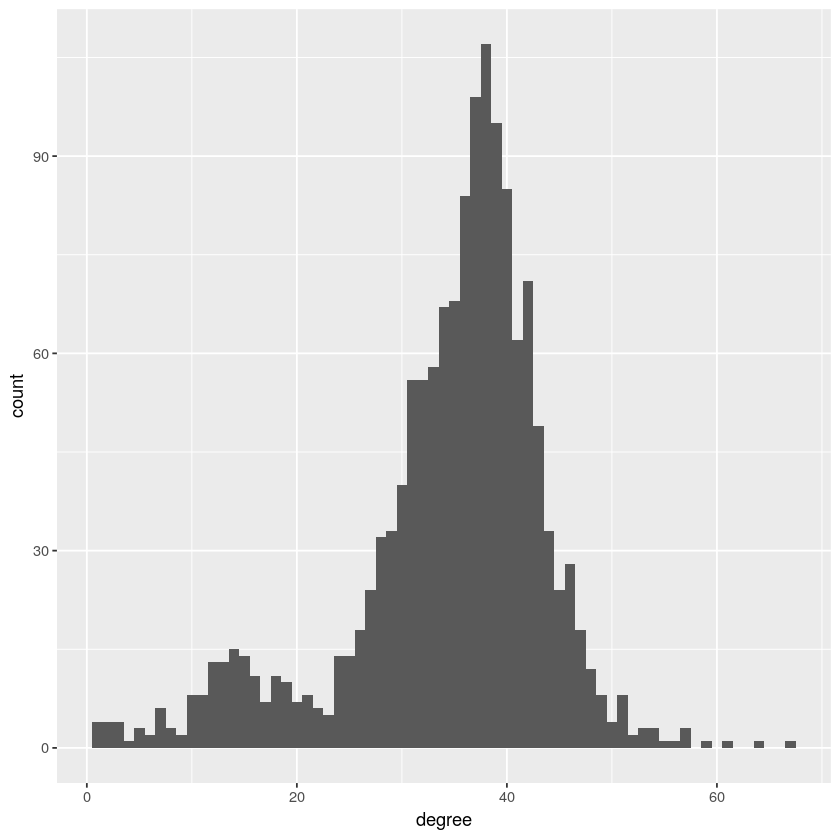

In [28]:
ggplot(
    ptEdges[, .(`degree`=.N), .(`source`)],
    aes(x=`degree`)
) +
    geom_histogram(binwidth=1)

### Connect the empirically observed edges